# Experiment 2
Given an actual (true) poisson sample, use regression to estimate $\lambda$ for this sample.
- Measure error relative to actual data

## Example
WW II London bombings  
see: [https://towardsdatascience.com/poisson-distribution-from-horse-kick-history-data-to-modern-analytic-5eb49e60fb5f]

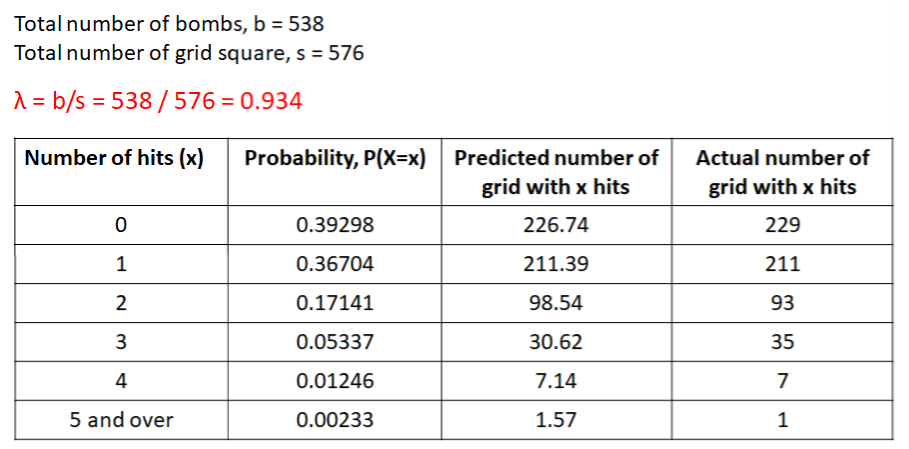


## Imports

In [1]:
# import library
%run lib.ipynb

a.shape: (3,)
len(a.shape): 1
b.shape: (2, 3)
len(b.shape): 2


## Experiment 2.1 - חישוב שגיאה סטטיסטית

1. Generate data ($N$ rows, $M$ poisson samples in a row, each row with a random $\lambda$ in the range $0.1 \le \lambda \le 10$)
2. $sample_i$ generated sinthetically with a specific $\lambda_i$ contains M samples ordered in a histogram $H_i$ with $m$ bins.
    - Fix $i$
    - for $k \in [\;0\;..\;m\;]$
        - $collect(poisson.pmf(k, \lambda) - H_{ik})$ -> statistical error in $sample_i$
    - calculate MSE(collection)
    - calculate MAE(collection)

In [2]:
def experiment_2_1():

    # 1. generate data

    M = 16  # num-samples
    print(f'generating {M} poisson samples ... ')
    raw, H, lambdas = generate_data(N=1, 
                                    M=M, 
                                    nextConfig=next_lambda, 
                                    sample=sample_poisson, 
                                    density=False, 
                                    dense_histogram=False)

    # 2. measure poisson statistical error

    with np.printoptions(precision=5, suppress=True):

        i = 0
        print(f'Poisson statistical error for sample(i = {i})')

        print()
        print(f'λ[i] : {lambdas[i]:.6f}')

        print()
        print(f'Raw samples (len={len(raw[0])}):')
        print(raw[i])

        # poisson generated (actual) values
        print()
        m = len(H[i])
        print(f'Histogram (num_bins={m}):')
        print(H[i])

        print()
        H_i_normalized = H[i] / np.sum(H[i])
        print(f'Normalized histogram (sum={np.sum(H_i_normalized)}):')
        print(H_i_normalized)

        # poisson calculated values
        print()
        print(f'Calculated values - pmf(k,λ)')
        poisson_pmf = np.array( [ poisson.pmf(k=j, mu=lambdas[i]) for j in range(m) ] )
        print(poisson_pmf)

        # MSE
        print()
        MSE = mean_squared_error(poisson_pmf, H_i_normalized)
        print(f'MSE: {MSE:.6f}    sqrt(MSE): {np.sqrt(MSE):.6f}')

        # MAE
        MAE = mean_absolute_error(poisson_pmf, H_i_normalized)
        print(f'MAE: {MAE:.6f}')

experiment_2_1()

generating 16 poisson samples ... 
Poisson statistical error for sample(i = 0)

λ[i] : 3.017184

Raw samples (len=16):
[2 4 2 2 4 4 1 1 2 1 3 3 5 3 3 2]

Histogram (num_bins=16):
[0 3 5 4 3 1 0 0 0 0 0 0 0 0 0 0]

Normalized histogram (sum=1.0):
[0.     0.1875 0.3125 0.25   0.1875 0.0625 0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.    ]

Calculated values - pmf(k,λ)
[0.04894 0.14766 0.22275 0.22403 0.16899 0.10197 0.05128 0.0221  0.00834
 0.00279 0.00084 0.00023 0.00006 0.00001 0.      0.     ]

MSE: 0.001113    sqrt(MSE): 0.033362
MAE: 0.021759


## Experiment 2.2 - חישוב השגיאה ביחס לנתונים אמיתיים

1. Fit a DNN regression *model* for $\lambda \in [\lambda_{min}\;...\;\lambda_{max}]$.
2. Given an actual poisson sample ordered in a histogram $H$ (without indices):  
   Feed $H$ to the *model* to predict $\lambda$
3. Measure the avg. error of the prediction relative to the actual values:  
   $MAE = avg\;(\;|\;P_j(\lambda)\;-\;H(\lambda)\;|\;)$

In [17]:
def experiment_2_2(N, M, test_lambda=0.92):
    
    # for reporoducable results
    reset_random_state(17)
    
    # constants
    density=False
    apply_log_scale=False
    
    # generate training data (histogram and lambdas)
    print(f'generating data (M={M}) ... ', end='')
    raw, H, lambdas = generate_data(N=N, 
                                    M=M, 
                                    nextConfig=next_lambda, 
                                    sample=sample_poisson, 
                                    density=density, 
                                    dense_histogram=True, 
                                    apply_log_scale=apply_log_scale)
    # fit model
    X_train, X_test, y_train, y_test = train_test_split(H, lambdas, test_size=0.25, random_state=RANDOM_STATE)
    print(f'X_train.shape: {X_train.shape}')
    print(f'fitting dnn model ... ', end='')
    start_time = time.time()
    dnn_model, history, y_pred, sqrt_mse = dnn_trial(X_train, y_train, X_test, y_test)
    train_time = round(time.time() - start_time)
    print(f'sqrt-mse: {sqrt_mse:.4f}, train-time: {round(train_time)} sec.')

    # generate test histogram
    print(f'test_lambda: {test_lambda:.6f}')
    test_samples = sample_poisson(mu=test_lambda, size=M) #lilo: size=10
    bins = X_train.shape[1] # same input size as training data
    test_histogram = np.apply_along_axis(
        lambda a: np.histogram(a, bins=bins, range=(0, bins), density=density)[0], 
        0, 
        test_samples)
    
    # apply log-scale also on test_histogram
    if apply_log_scale:
        test_histogram = log_scale(test_histogram)
    
    test_pmf = test_histogram / np.sum(test_histogram)
    
    # predict lambda for the actual histogram
    test_input = np.reshape(test_histogram, (1,-1))
    predicted_lambda = dnn_model.predict(test_input).flatten()[0]
    print(f'predicted_lambda: {predicted_lambda:.6f}')
    predicted_pmf = np.array([poisson.pmf(k=i, mu=predicted_lambda) for i in range(bins)])

    # MSE
    print()
    MSE = mean_squared_error(test_pmf, predicted_pmf)
    print(f'MSE: {MSE:.6f}    sqrt(MSE): {np.sqrt(MSE):.6f}')

    # MAE
    MAE = mean_absolute_error(test_pmf, predicted_pmf)
    print(f'MAE: {MAE:.6f}')

# experiment_2_2(N=10000, M=64, test_lambda=0.92)    # predicted_lambda: 0.854302

# experiment_2_2(N=10000, M=256, test_lambda=0.33)   # predicted_lambda: 0.339323
experiment_2_2(N=10000, M=256, test_lambda=0.92)   # predicted_lambda: 0.922885
# experiment_2_2(N=10000, M=256, test_lambda=2.00)   # predicted_lambda: 2.000334
# experiment_2_2(N=10000, M=256, test_lambda=1.56)   # predicted_lambda: 1.568572
# experiment_2_2(N=10000, M=256, test_lambda=3.52)   # predicted_lambda: 3.665080
# experiment_2_2(N=10000, M=256, test_lambda=9.89)   # predicted_lambda: 9.967596

# experiment_2_2(N=10000, M=512, test_lambda=0.92)   # predicted_lambda: 0.930573
# experiment_2_2(N=10000, M=8192, test_lambda=0.92)  # predicted_lambda: 1.017836
# experiment_2_2(N=10000, M=16384, test_lambda=0.92) # predicted_lambda: 0.750495


generating data (M=256) ... X_train.shape: (7500, 26)
fitting dnn model ... sqrt-mse: 0.1465, train-time: 23 sec.
test_lambda: 0.920000
predicted_lambda: 0.922885

MSE: 0.000109    sqrt(MSE): 0.010442
MAE: 0.003471


## Experiment 2.3
Predict $\lambda$ for actual data using a specific regression model (overfit).
- auto-encoder single neuron at the middle?
- just like by-hand?

In [4]:
# TODO